# Assignment 1

## Step 1: Acquisition

First, I borrow heavily from the provided jupyter notebook in order to construct working API calls from wikimedia. Below I use a sample call from both the legacy and new pageviews endpoints, and next enumerate the parameters used in each of my five calls to get monthly page view data from each access type. For the new pageviews endpoint, I make sure to specify user agent in addition to the other fields. 

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [8]:
# Parameters for API call for legacy endpoint, desktop site data
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

# Parameters for API call for legacy endpoint, mobile site data
params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2014100100",
                 "end" : "2016080100"
                    }

In [10]:
# Parameters for API call for pageviews endpoint, desktop site data
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                 "access" : "desktop",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2019090100"
                    }

# Parameters for API call for pageviews endpoint, mobile web data
params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                 "access" : "mobile-web",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2019090100"
                    }

# Parameters for API call for pageviews endpoint, mobile app data
params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                 "access" : "mobile-app",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2019090100"
                    }

# Personal header information
headers = {
    'User-Agent': 'https://github.com/zacharyfgarcia',
    'From': 'garciz@uw.edu'
}

In [5]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In this section, I issue the five API calls, writing the data from each directly to disk with file names aligned with the Assignment 1 naming convention. 

In [6]:
# Write legacy desktop mothly pagecounts to disk
legacy_desktop_monthly_pageviews = api_call(endpoint_legacy, params_legacy_desktop)
with open('pagecounts_desktop-site_200712-201608.json', 'w') as outfile:
    json.dump(legacy_desktop_monthly_pageviews, outfile)

In [9]:
# Write legacy mobile monthly pagecounts to disk
legacy_mobile_monthly_pageviews = api_call(endpoint_legacy, params_legacy_mobile)
with open('pagecounts_mobile-site_201410-201608.json', 'w') as outfile:
    json.dump(legacy_mobile_monthly_pageviews, outfile)

In [12]:
# Write desktop monthly pageviews to disk
desktop_monthly_pageviews = api_call(endpoint_pageviews, params_pageviews_desktop)
with open('pageviews_desktop_201507-201909.json', 'w') as outfile:
    json.dump(desktop_monthly_pageviews, outfile)

In [13]:
# Write mobile web monthly pageviews to disk
mobileweb_monthly_pageviews = api_call(endpoint_pageviews, params_pageviews_mobileweb)
with open('pageviews_mobile-web_201507-201909.json', 'w') as outfile:
    json.dump(mobileweb_monthly_pageviews, outfile)

In [14]:
# Write mobile app monthly pageviews to disk
mobileapp_monthly_pageviews = api_call(endpoint_pageviews, params_pageviews_mobileapp)
with open('pageviews_mobile-app_201507-201909.json', 'w') as outfile:
    json.dump(mobileapp_monthly_pageviews, outfile)

## Step 2: Processing

First, I initalized an empty dataframe that I could use to put all my page counts into post-processing. A bit of math showed that we had 141 total months of data and all desired column names were provided in the assignment instructions. 

In [126]:
# Initalize dataframe with proper headers
import pandas as pd
import numpy as np

# I did this math manually, 3 months short of 12 years
n_months = 141
columns = ['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
           'pageview_all_views','pageview_desktop_views','pageview_mobile_views']
total_traffic = pd.DataFrame(index=range(0,n_months),columns=columns)

Next, since the data was monthly so the timestamps were just counting up month by month, I figured it would be easier to populate the year and month columns of the dataframe myself rather than trying to parse it from the timestamps. The below code just has some simple logic for counting through the desired time window and casting years and months into the desired strings. 

In [127]:
# Initialize year and month columns by iterating through the months
year = 2007
month = 12
for i in range(0,n_months):
    total_traffic.loc[i, 'year'] = str(year)
    total_traffic.loc[i,'month'] = str(month).zfill(2)
    if month == 12:
        year = year + 1
        month = 1
    else:
        month = month + 1

Here I initialize the rest of the values to zero. Any page count value that I don't explicitly set or calculate later will be zero, which is desired. 

In [135]:
# Initialize all page counts to zero
for i in range(0,n_months):
    total_traffic.loc[i,'pagecount_all_views'] = 0
    total_traffic.loc[i,'pagecount_desktop_views'] = 0
    total_traffic.loc[i,'pagecount_mobile_views'] = 0
    total_traffic.loc[i,'pageview_all_views'] = 0
    total_traffic.loc[i,'pageview_desktop_views'] = 0
    total_traffic.loc[i,'pageview_mobile_views'] = 0

This part actually caused me the greatest headache in the whole process: actually getting from the JSON object to the page view counts inside. There seemed to be some strange nesting behavior where a single "items" object was storing several dicts inside, but I couldn't find a way to iterate into the actual dicts. My eventual solution was to manually remove the "items" wrapper in the saved JSON files and then load what was left into Pandas Data Frames, and that seemed to do the trick. 

In [136]:
# Read in items-less page view JSON files into data frames
with open('pageviews_mobile-app_201507-201909.json') as json_file:
    mobileapp_pageviews = json.load(json_file)
mobileapp = pd.DataFrame(mobileapp_pageviews)

with open('pageviews_mobile-web_201507-201909.json') as json_file:
    mobileweb_pageviews = json.load(json_file)
mobileweb = pd.DataFrame(mobileweb_pageviews)

In [145]:
# Load the remaining JSON files in the same way
with open('pagecounts_desktop-site_200712-201608.json') as json_file:
    desktop_site_pagecounts = json.load(json_file)
desktop_site = pd.DataFrame(desktop_site_pagecounts)

with open('pagecounts_mobile-site_201410-201608.json') as json_file:
    mobile_site_pagecounts = json.load(json_file)
mobile_site = pd.DataFrame(mobile_site_pagecounts)

with open('pageviews_desktop_201507-201909.json') as json_file:
    desktop_pageviews = json.load(json_file)
desktop = pd.DataFrame(desktop_pageviews)

Next, in order to place the data into the right spots, I calculated month indices that corresponded to when data began and ended for the various endpoint+access combos. Assuming December 2007 was month 0, the page views endpoint went up at month 91 and the mobile site page counts endpoint went up at month 82. Both page count endpoints ended at month 104. Then I just dropped the data in to the data frame, making sure to get the columns right and to offset the index of the read data so it started at 0. 

In [141]:
# Month that pageviews endpoint went up
pv_start = 91

# Adding mobile app views and mobile web views to get total mobile pageviews
for i in range (pv_start,n_months):
    total_traffic.loc[i,'pageview_mobile_views'] = mobileapp.loc[i - pv_start,'views'] + mobileweb.loc[i - pv_start,'views']

In [147]:
# Pump in desktop pagecount
for i in range(desktop_site.shape[0]):
    total_traffic.loc[i,'pagecount_desktop_views'] = desktop_site.loc[i,'count']

In [149]:
# Pump in mobile pagecount
ms_start = 82
ms_end = 104
for i in range(ms_start, ms_end):
    total_traffic.loc[i,'pagecount_mobile_views'] = mobile_site.loc[i-ms_start,'count']

In [151]:
# Pump in desktop page views
for i in range(pv_start,n_months):
    total_traffic.loc[i,'pageview_desktop_views'] = desktop.loc[i-pv_start,'views']

In order to get total page counts and page views I added the mobile and desktop views from the existing dataframe that were already calculated. Finally, I wrote the dataframe to disk. 

In [155]:
# Calculate total pagecounts
for i in range(n_months):
    total_traffic.loc[i,'pagecount_all_views'] = total_traffic.loc[i,'pagecount_desktop_views'] + total_traffic.loc[i,'pagecount_mobile_views']

In [156]:
# Calculate total pageviews
for i in range(n_months):
    total_traffic.loc[i,'pageview_all_views'] = total_traffic.loc[i,'pageview_desktop_views'] + total_traffic.loc[i,'pageview_mobile_views']

In [158]:
# Write dataframe to CSV
total_traffic.to_csv('en-wikipedia_traffic_200712-201809.csv')

## Step 3: Analysis

In order for my year and month strings to be parsed as ordered dates, I did a bit of stack overflow searching to find that I could use the datetime package, append the dates I desired, and then pass it in as the x value in any plots created. Below I add one date for the start of each month in my data. 

In [168]:
import matplotlib.pyplot as plt
import datetime as dt

# Initialize date range
dates = []
dates.append(dt.datetime(year=2007, month=12,day=1))
for year in range(2008, 2019):
    for month in range(1, 13):
        dates.append(dt.datetime(year=year, month=month, day=1))
for month in range(1,9):
    dates.append(dt.datetime(year=2019, month=month, day=1))

In plotting my final figure, I first increased the size so the final file wasn't too small and the legend didn't block the data. Next, I plot all of my six calculated page count breakdowns over time, giving them each a color. Desktop traffic is green, mobile is blue, and the sum of desktop and mobile is black. Legacy counts are shown in dotted lines and updated definition counts for the page views endpoint is shown in solid lines. I divide all values by 1 billion to keep the scale less confusing and add the (in billions) to the y-axis label. One big issue I see that I tried a bit to fix but couldn't find an easy way to do so was to remove all non-zero values from the plot without changing the data so that the jarring lines going from or to zero were removed. 

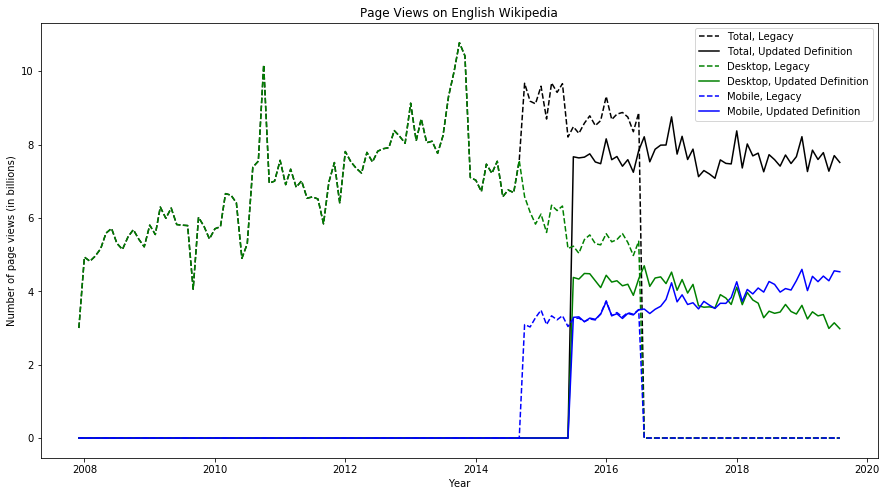

In [184]:
# Plot page counts onto a figure
plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(dates, total_traffic['pagecount_all_views']/1000000000, color='black',linestyle='dashed',label='Total, Legacy')
plt.plot(dates, total_traffic['pageview_all_views']/1000000000, color='black',label='Total, Updated Definition')
plt.plot(dates, total_traffic['pagecount_desktop_views']/1000000000, color='green',linestyle='dashed',label='Desktop, Legacy')
plt.plot(dates, total_traffic['pageview_desktop_views']/1000000000, color='green',label='Desktop, Updated Definition')
plt.plot(dates, total_traffic['pagecount_mobile_views']/1000000000, color='blue',linestyle='dashed',label='Mobile, Legacy')
plt.plot(dates, total_traffic['pageview_mobile_views']/1000000000, color='blue',label='Mobile, Updated Definition')
plt.xlabel('Year')
plt.ylabel('Number of page views (in billions)')
plt.title('Page Views on English Wikipedia')
plt.legend()
plt.savefig('Final_Visualization.png')
plt.show()